In [1]:
import pickle
from collections import defaultdict
from time import sleep
import re

import ipywidgets as ipyw
from matplotlib import pyplot as plt
import numpy as np
import numba
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from scipy.stats import kendalltau
import seaborn as sns
from sklearn.cluster import SpectralClustering
from tqdm import tqdm

import rcimport
import rankcentrality as rank
from rankcentrality import siamese

In [2]:
pd.set_option("display.max_colwidth", None)

In [3]:
csvfile = "data/651_summary_KLUCB.csv"
sampling = "top400"

contest = re.match("[^\d]*(\d+).*", csvfile).groups()[0]
print(f"Loading data from contest {contest}")
summdf = pd.read_csv(csvfile)

inds = dict(
    top200=np.arange(200),
    top400=np.arange(400),
    rand200=np.random.choice(400, 200, False),
    rand400=np.random.choice(800, 400, False),
)[sampling]
filtered_df = summdf.iloc[inds]
_avg_score = filtered_df["score"].to_numpy()
captions = filtered_df["caption"].to_numpy().tolist()
scores = _avg_score
index = filtered_df["target_id"].to_numpy()

Loading data from contest 651


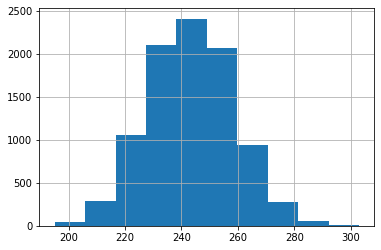

In [4]:
summdf["count"].hist()

In [5]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(module_url)

In [6]:
X = embed(captions).numpy()

In [7]:
spectral_clustering = SpectralClustering(20)
clusts = spectral_clustering.fit_predict(X)

In [8]:
reind = np.argsort(clusts, kind="stable")

In [9]:
D = rank.RankCentrality.get_diffusion_matrix(
    None, X, 0.3, 0.1, "cosine"
)  # , stochastic=False)

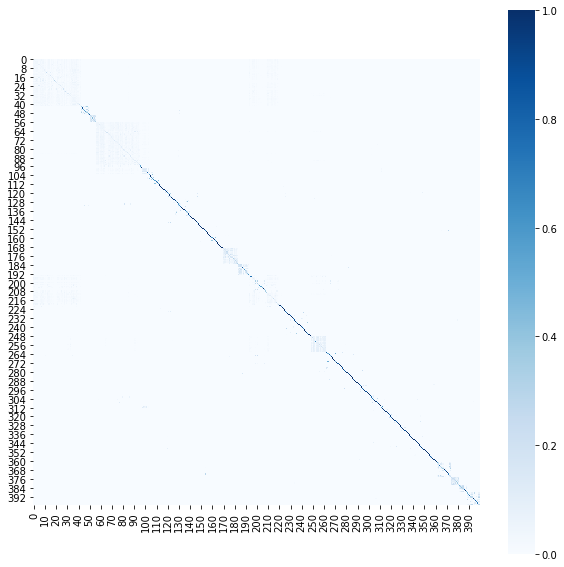

In [10]:
fig = plt.figure(figsize=(10, 10))
g = sns.heatmap(
    D[reind, :][:, reind],
    # vmin=0,
    # vmax=.2,
    square=True,
    cmap="Blues",
)
# fig.savefig("../output/nyheatmap.pdf", bbox_inches='tight')

In [11]:
df_captions = pd.DataFrame(dict(scores=scores, captions=captions, index=index))

In [12]:
@ipyw.interact(
    c=ipyw.BoundedIntText(
        value=0, min=0, max=np.max(clusts), description="Cluster"
    )
)
def printclust(c):
    return df_captions.iloc[clusts == c]

,scores,captions,index
37,1.605263,Says here you’re covered by COBRA?,8248
48,1.592742,"Luckily, you're covered by Cobra.",5417
57,1.587121,I can see here that you’re covered by COBRA.,6065
58,1.584821,I see that you're covered by COBRA.,5236
65,1.576613,I see here that you're covered by COBRA,478
75,1.569853,The good news is you’re covered by COBRA.,8484
86,1.561702,I see you're still covered by COBRA.,3506
92,1.557196,"Luckily, you're covered under COBRA.",1346
102,1.552301,I see you’re covered under COBRA,4138
103,1.551867,I see you're covered by COBRA.,1906


In [13]:
df_captions.iloc[clusts == 0]["index"].to_numpy()

array([8248, 5417, 6065, 5236,  478, 8484, 3506, 1346, 4138, 1906, 4472,
       1053, 8110, 8418, 2679, 8856, 4680, 6187, 5482, 6025, 3354, 8895,
       7023, 1490, 7946,  354, 8930, 9128, 1544, 5373, 6203, 9138, 6918,
       3604, 1879, 1085,  417, 3633, 8335, 6239, 5067,  770, 8398])

In [14]:
np.random.seed(1234)  # to make results reproducible for discussions
# np.random.seed() # to let numpy seed random generator

In [15]:
n_points = len(captions)

## Vary Widths

In [16]:
num_draws = 10
widths_arr = np.linspace(0.01, 0.5, 11)
scores_hat_diffrc = defaultdict(lambda: [[] for _ in widths_arr])
for n_comps in tqdm([(n_points // 10) * 2 ** i for i in range(1, 7)]):
    for _ in range(num_draws):
        comps, comp_results = rank.generate.simulate_comparisons(
            scores, n_comps
        )
        rc = rank.RankCentrality(n_points, comps, comp_results)
        for width_ind, width in enumerate(widths_arr):
            scores_hat_diffrc[f"{n_comps} comparisons"][width_ind].append(
                rc.run_diffused_decayed(
                    X, width, metric="cosine", lam=np.exp(-3)
                )
            )

100%|██████████| 6/6 [01:58<00:00, 19.74s/it]


In [17]:
loss = "kt"

In [18]:
# compute_experiment_metrics expects that
# dict["algorithm"][num_comps_index][repetition_index] is of type Scores.
# scores_hat_diffrc[num_comps][width_index][repetition_index] is of type Scores
metrics = rank.stats.compute_experiment_metrics(
    scores_hat_diffrc, scores, loss, len(widths_arr), num_draws
)

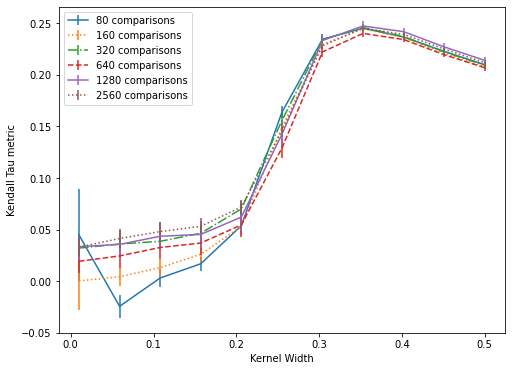

In [19]:
f, ax = rank.stats.plot_experiment_metrics(
    metrics,
    num_comps_list=widths_arr,
    loss=loss,
    num_comps_label="Kernel Width",
)
ax.set_xscale("linear")
f.set_figheight(6)
f.set_figwidth(8)

In [20]:
df = rank.stats.experiment_metrics_to_dataframe(metrics, widths_arr)
df.index.name = "width"
df

,80 comparisons,80 comparisons_std_err,160 comparisons,160 comparisons_std_err,320 comparisons,320 comparisons_std_err,640 comparisons,640 comparisons_std_err,1280 comparisons,1280 comparisons_std_err,2560 comparisons,2560 comparisons_std_err
width,,,,,,,,,,,,
0.010,0.044717,0.045013,0.000208,0.027836,0.031993,0.007331,0.019200,0.010904,0.033384,0.012698,0.032981,0.008900
0.059,-0.024468,0.011293,0.004198,0.008606,0.035965,0.007155,0.024397,0.011267,0.035619,0.013645,0.041285,0.009249
0.108,0.002992,0.008772,0.013070,0.008696,0.038601,0.007998,0.032589,0.011628,0.043462,0.013806,0.048002,0.009429
0.157,0.016795,0.006872,0.025973,0.009027,0.046402,0.008185,0.036918,0.012080,0.045276,0.013330,0.053134,0.007997
0.206,0.053663,0.006197,0.053061,0.007880,0.069967,0.008024,0.054448,0.011914,0.062071,0.013322,0.071873,0.006740
0.255,0.163666,0.005703,0.149166,0.007183,0.155567,0.008415,0.128912,0.009634,0.142291,0.010890,0.145808,0.005775
0.304,0.234528,0.004350,0.229544,0.004146,0.234217,0.005067,0.222265,0.005164,0.233322,0.006245,0.228238,0.003596
0.353,0.245243,0.002979,0.244772,0.002672,0.245910,0.003833,0.240169,0.003242,0.247410,0.004366,0.245183,0.002021
0.402,0.236678,0.002025,0.236098,0.002265,0.237142,0.002465,0.234227,0.002715,0.241877,0.003523,0.239234,0.001984


In [21]:
df.to_csv(f"../output/ny{contest}_synthetic_variablewidths.csv")

## Compare algorithms

In [22]:
n_comps_arr = np.array((n_points // 10) * (2 ** np.arange(13)))

In [23]:
kernel_width = 0.25
threshold = 0
diff_time = 1

In [24]:
np.random.seed(0)  # to make results reproducible for discussions

In [ ]:
num_draws = 20
what_dict = defaultdict(lambda: [[] for _ in n_comps_arr])
for m_ind, n_comps in enumerate(tqdm(n_comps_arr, desc="num_comps")):
    for _ in range(
        num_draws
    ):  # tqdm(range(num_draws), desc="draws", leave=False):
        sleep(0.00001)  # odd ARPACK errors without this...
        comps, comp_results = rank.generate.simulate_comparisons(
            scores, n_comps
        )
        rc = rank.RankCentrality(n_points, comps, comp_results)
        what_dict["regRC"][m_ind].append(rc.run_regularized_decayed(5))
        what_dict["diffRC"][m_ind].append(
            rc.run_diffused_decayed(
                X, kernel_width, metric="cosine", lam=np.exp(-3)
            )
        )
        btl = rank.BTLMLE(n_points, comps, comp_results)
        what_dict["BTL-MLE"][m_ind].append(btl.run())
        ranksvm = rank.RankSVM(n_points, comps, comp_results, X)
        what_dict["RankSVM"][m_ind].append(ranksvm.run())
        ranksvm_rf = rank.RankSVM(n_points, comps, comp_results, X)
        what_dict["RF-RankSVM"][m_ind].append(ranksvm_rf.run_random_features())
        snn = siamese.SiameseNetRank(n_points, comps, comp_results, X)
        what_dict["SNN"][m_ind].append(snn.run())

num_comps:  85%|████████▍ | 11/13 [10:53<04:22, 131.11s/it]

In [ ]:
loss = "ete"

In [ ]:
metrics = rank.stats.compute_experiment_metrics(
    what_dict, scores, loss, len(n_comps_arr), num_draws
)

In [ ]:
f, ax = rank.stats.plot_experiment_metrics(metrics, n_comps_arr, loss)
f.set_figheight(6)
f.set_figwidth(8)

In [ ]:
bayes = rank.stats.expected_test_error(scores, scores)
bayes

In [ ]:
df = rank.stats.experiment_metrics_to_dataframe(metrics, widths_arr)
if loss == "ete":
    df["bayes"] = bayes
df

In [ ]:
df.to_csv(
    f"../output/ny{contest}_synthetic_width{kernel_width}_loss{loss}.csv"
)